Andrew Marasco \
Customer Churn Prediction Model \
Flatiron School Capstone Project #1 \
January, 2026

## Step 0: Setup and Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Step 1: Data Acquisition/Understanding

Cloning GitHub repo into Colab Notebook

In [3]:
!git clone https://github.com/andrewmarasco/Capstone_Project__Customer_Churn_Binary_Classification.git


Cloning into 'Capstone_Project__Customer_Churn_Binary_Classification'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 5), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 386.95 KiB | 2.10 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
!ls

Capstone_Project__Customer_Churn_Binary_Classification	sample_data


In [5]:
!ls Capstone_Project__Customer_Churn_Binary_Classification

archive.zip  Customer_Churn_Classification_AM.ipynb  Telco_Cusomer_Churn.csv


Loading Telco Customer Dataset into Colab

In [6]:
import pandas as pd

DATA_PATH = (
    "Capstone_Project__Customer_Churn_Binary_Classification/"
    "Telco_Cusomer_Churn.csv"
)

df = pd.read_csv(DATA_PATH)

df.shape, df.head()

((7043, 21),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV Streamin

Checking Dataset Schema

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Checking Target Distribution

In [8]:
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)


,proportion
Churn,
No,0.73463
Yes,0.26537


Data Quality Scan

In [9]:
df.isna().sum().sort_values(ascending=False)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


## Step 2: Data Cleaning

Diagnosing 'TotalCharges' Issue (is object)

In [10]:
df["TotalCharges"].head(20)

,TotalCharges
0,29.85
1,1889.5
2,108.15
3,1840.75
4,151.65
5,820.5
6,1949.4
7,301.9
8,3046.05
9,3487.95


In [11]:
df["TotalCharges"].value_counts().head(10)

,count
TotalCharges,
,11
20.2,11
19.75,9
20.05,8
19.9,8
19.65,8
19.55,7
45.3,7
20.15,6


In [12]:
# Converting TotalCharges to numeric, coercing blanks to NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Checking how many NaNs we now have
df["TotalCharges"].isna().sum()


np.int64(11)

In [13]:
df.loc[df["TotalCharges"].isna(), ["tenure", "MonthlyCharges", "TotalCharges"]]


,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


Dropping Identifier (CustomerID)

In [14]:
df = df.drop(columns=["customerID"])

Encoding Target Cleanly

In [15]:
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [16]:
y = (df["Churn"] == "Yes").astype(int)
X = df.drop(columns=["Churn"])

y.mean()

np.float64(0.2653698707936959)

Splitting Data to Avoid Peeking

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((5634, 19),
 (1409, 19),
 np.float64(0.2653532126375577),
 np.float64(0.2654364797728886))

## Step 3: Exploratory Data Analysis

Churn Rate By Key Categorical Features

In [18]:
def churn_rate_by_feature(X, y, feature):
  temp = X[[feature]].copy()
  temp["churn"] = y.values
  return (
      temp.groupby(feature)["churn"]
      .mean()
      .sort_values(ascending=False)
  )

In [19]:
for col in ["Contract", "PaymentMethod", "InternetService", "TechSupport"]:
  print(f"\nChurn Rate By {col}:")
  print(churn_rate_by_feature(X_train, y_train, col))


Churn Rate By Contract:
Contract
Month-to-month    0.427466
One year          0.110827
Two year          0.028698
Name: churn, dtype: float64

Churn Rate By PaymentMethod:
PaymentMethod
Electronic check             0.457430
Mailed check                 0.192846
Bank transfer (automatic)    0.161576
Credit card (automatic)      0.149217
Name: churn, dtype: float64

Churn Rate By InternetService:
InternetService
Fiber optic    0.420862
DSL            0.186887
No             0.072488
Name: churn, dtype: float64

Churn Rate By TechSupport:
TechSupport
No                     0.417539
Yes                    0.151607
No internet service    0.072488
Name: churn, dtype: float64


Numeric Features vs Churn

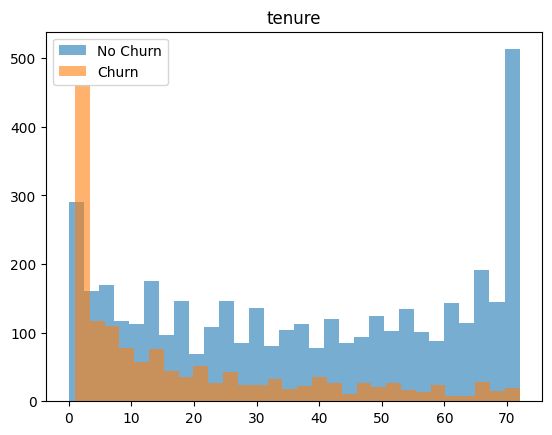

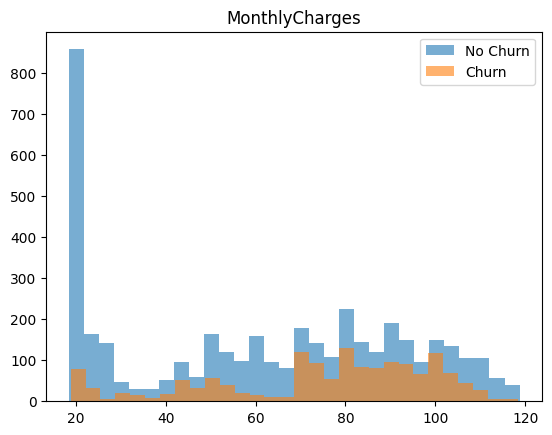

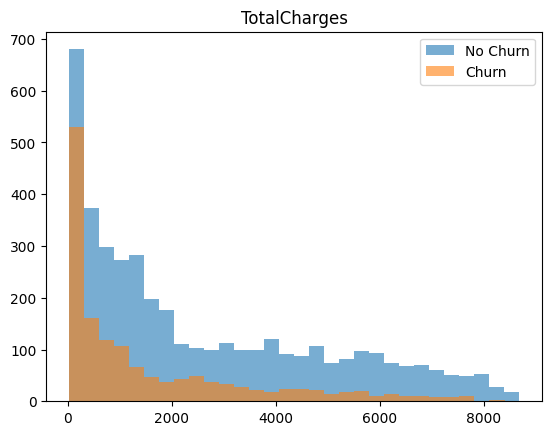

In [20]:
import matplotlib.pyplot as plt

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
  plt.figure()
  plt.hist(X_train.loc[y_train == 0, col], bins=30, alpha=0.6, label="No Churn")
  plt.hist(X_train.loc[y_train == 1, col], bins=30, alpha=0.6, label="Churn")
  plt.title(col)
  plt.legend()
  plt.show()

EDA Summary/Key Insights: \
-Customers on month-to-month contracts churn at significantly higher rates. \
-Eletronic check payment method is associated with higher churn. \
-Lower tenure customers are much more likely to churn. \
-Higher monthly charges appear correlated to increased churn risk. \
-Customers without tech support services are substantially more likely to \
churn. \
-Fiber optic internet customers churn at higher rates than DSL or no-internet.

## Step 4: Building Preprocessing Pipeline

Step 4.1: Identify Column Types

In [21]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

numeric_features, categorical_features

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

Step 4.2: Building Preprocessing Pipeline

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

assert "gender" not in numeric_features, "Gender is incorrectly in numeric_features"
assert "TotalCharges" in numeric_features, "TotalCharges is not numeric"
assert "gender" in categorical_features, "gender is missing from categorical_features"

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Building Preprocess Object
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

Xt = preprocess.fit_transform(X_train)
print("SUCCESS: preprocess.fit_transform works. Transformed shape:", Xt.shape)

Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
SUCCESS: preprocess.fit_transform works. Transformed shape: (5634, 45)


## Step 5: Building Baseline Model - Logistic Regression

Step 5.1: Building Logistic Regression Pipeline + Baseline Cross-Validation

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

logreg_pipe = Pipeline(steps=[
  ("preprocess", preprocess),
  ("model", LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
  ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

logreg_cv = cross_validate(
    logreg_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
    )

{m: logreg_cv[f"test_{m}"].mean() for m in scoring}

{'roc_auc': np.float64(0.8459495012172488),
 'precision': np.float64(0.5164818566895508),
 'recall': np.float64(0.8013377926421403),
 'f1': np.float64(0.6279272719115523)}

Baseline Model Performance - Logistic Regression

ROC-AUC = 0.846
The baseline logistic regression model above acheived an ROC-AUC of 0.846, which indicates it has strong overall class seperation.

Recall = 0.80
This is very good for our first model. If 100 customers will churn, the model will 'flag' about 80 of them. This indicates it could work well for building a procative retention targeting system.

Precision = 0.52
Not as impressive, but still acceptable. About half of the customers the model flags will actually churn. This represents an acceptable trade-off in retention use cases where outreach cost is comparatively low.

F1 = 0.63
Balanced summary of precision and recall.

This baseline establishes a robust benchmark for comparison against more complex ensemble models.

## Step 6: Building Model 2 (Random Forest)

Now we will test if non-linear modeling can offer improved performance.

Step 6.1: Building Random Forest Pipeline

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_cv = cross_validate(
    rf_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

{m: rf_cv[f"test_{m}"].mean() for m in scoring}

{'roc_auc': np.float64(0.8209998782663319),
 'precision': np.float64(0.6309691215585516),
 'recall': np.float64(0.47157190635451507),
 'f1': np.float64(0.5395115429176098)}

ROC-AUC:   0.821 (Baseline Model = 0.846) \
Precision: 0.631 (Baseline Model = 0.52) \
Recall:    0.472 (Baseline Model = 0.80) \
F1:        0.540 (Baseline Model = 0.63) \

Baseline model catches about 80% of churners and is better for implementing an aggressive retention strategy. \
Random Forest has much higher precision, but misses more than half of churners (47%) and it better for conservatice targeting.

In this business situation, I consider recall to be more important \
than precision, since missing outreach to churners will be costlier \
than waste incurred by contacting non-churning customers.

Random Forest may have underperformed for a number of reasons. \
Some possibilities:
1. Logistic Relationships are strong (contract, tenure)
2. The data is not very nonlinear
3. Default RF hyperparameters are not yet tuned.
4. Class imbalance handling might affect tree splits differently

## Step 7: Adding Boosting

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(
        max_iter=300,
        random_state=42
    ))
])

hgb_cv = cross_validate(
    hgb_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

{m: hgb_cv[f"test_{m}"].mean() for m in scoring}

{'roc_auc': np.float64(0.8247985328309021),
 'precision': np.float64(0.6129868460633905),
 'recall': np.float64(0.5063545150501673),
 'f1': np.float64(0.5544716801257442)}

Boosting Metrics: \
ROC-AUC: 0.825 \
Precision: 0.613 \
Recall: 0.506 \
F1: 0.554 \

Between these three options so far, Logistic Regression is currently the strongest candidate model. It has: \
Best ROC-AUC \
Best Recall \
Best F1 \
Fully interpretable \

Tree models are more conservative, flagging fewer customers but with greater confidence.

In a churn-prediction situation like this, a business prefers higher recall even at the cost of precision. Therefore Logistic Regression is currently the best business-aligned model.

## Step 8: Tuning Logistic Regression Model

In [30]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

param_dist = {
    "model__C": np.logspace(-3, 2, 20)
}

logreg_search = RandomizedSearchCV(
    logreg_pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

logreg_search.fit(X_train, y_train)

logreg_search.best_score_, logreg_search.best_params_

(np.float64(0.8462274568285546), {'model__C': np.float64(16.23776739188721)})

Logistic Regression - Tuned Results: \
Best CV ROC-AUC: 0.8462 \
Best C: 16.24 \

The ROC did not significantly change. This suggests that the baseline logistic regression model was already close to optimal.

The Best C = 16.24 indicates relatively weak regularization and that the model benefits from flexibility.

Overall, these outputs suggest further that the dataset is clean and the model is stable.

At this point, it appears Logistic Regression is outperforming both treel models, tuning did not significantly improve performance, and the model is stable and interpretable.

## Step 9: Finat Test Evaluation

In [32]:
best_logreg = logreg_search.best_estimator_

best_logreg.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_proba = best_logreg.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


Test ROC-AUC: 0.8404531245963471

Confusion Matrix:
[[749 286]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0      0.902     0.724     0.803      1035
           1      0.506     0.783     0.615       374

    accuracy                          0.740      1409
   macro avg      0.704     0.754     0.709      1409
weighted avg      0.797     0.740     0.753      1409



Final Test Results - Logistic Regression \

ROC-AUC: 0.840 \
Very consistent with CV, no overfitting, stable model. \

Confusion Matrix: \
Recall (Churn Class): 0.783 \
We correctly identified about 78%.
Out of 374 actual churners, our model correctly flagged 293 and missed 81. \

Precision (Churn Class): 0.506 \
About 51% of customers we identified as 'high risk' would actually churn. \
Out of 579 customers flagged by the model, about half will truly churn. \

Accuracy: 74% \
Not very meaningful for imbalanced problems... recall matters more here. \

Executive Translation: \
If we target flagged customers: \
We would contact 579 customers. \
We would prevent churn for up to 293 of them (if retention strategy were successful). \
We would miss 81 churners. \

## Step 10: Threshold Optimization

In [33]:
import numpy as np
import pandas as pd

thresholds = np.linspace(0.1, 0.9, 17)

results = []

for t in thresholds:
  preds = (y_proba >= t).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0

  results.append({
      "threshold": t,
      "precision": precision,
      "recall": recall
  })

pd.DataFrame(results)

,threshold,precision,recall
0,0.10,0.341959,0.989305
1,0.15,0.368209,0.978610
2,0.20,0.391304,0.962567
3,0.25,0.410047,0.938503
4,0.30,0.429988,0.927807
5,0.35,0.445323,0.903743
6,0.40,0.463519,0.866310
7,0.45,0.486025,0.836898
8,0.50,0.506045,0.783422
9,0.55,0.521336,0.751337


In [ ]:
""